In [1]:
###Pandas Libraries
import pandas as pd
import datetime
import time
import os

#Dash Libraries
#import dash  # USE THIS IF RUNNING ON SERVER
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
#import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from jupyter_dash import JupyterDash # USE THIS IF RUNNING ON JUPYTER
import numpy as np

##  TABLE MANIPULATION CODE

In [106]:
#*********                     FUNCTION RUNS ALL OF THE DATA MANIPULATION CODE
#start = time.time()  ## TIMER FUNCTION

#Convert Hour of Day to time period
timeconv = {'Admission_Period':['Planned','Unplanned','Unplanned','Unplanned','Unplanned','Planned',
                                'Planned','Planned','Planned','Unplanned','Unplanned','Unplanned',
                                'Unplanned','Unplanned','Unplanned','Unplanned','Unplanned','Planned',
                                'Planned','Planned','Planned','Planned','Planned','Planned'],
            'Hour_of_Day': [0,1,2,3,4,5,
                            6,7,8,9,10,11,
                            12,13,14,15,16,17,
                            18,19,20,21,22,23]}
timeconv_df = pd.DataFrame.from_dict(timeconv)

dayconv = {'Day_Type':['Weekday','Weekday','Weekday','Weekday','Weekday','Weekend','Weekend'],
           'Day': [0,1,2,3,4,5,6]}
dayconv_df = pd.DataFrame.from_dict(dayconv)

event_activity = {'Event_Activity':['High','High','High','Low','Normal','Normal','Low','Low'],
                  'Event':['AFTERXMAS','B4EASTER','BEFOREXMAS','EASTER','NONE','SCHOOL','XMAS','PUBLIC']}
event_activity_df = pd.DataFrame.from_dict(event_activity)


##### CLEAN TRANSFERS DATA
df = pd.read_csv('transfers.csv')
df = df.rename(columns = {'Start_Bed_Dttm':'Start', 'End_Bed_Dttm':'End'})
df = df.drop(columns=['Transfers', 'Bed_Code', 'Full Flow Code', 'Current Flow Code', '1st Level','PASID'])
date_cols = ['Start', 'End']
df[date_cols] = df[date_cols].apply(pd.to_datetime, format='%d/%m/%y %H:%M', errors='raise')
base_df = df.copy(deep=True)
ideal_df = df.copy(deep=True)
orig_df = df.copy(deep=True)

###### CLEAN EVENTS AND PUBLIC HOLIDAY DATA
events_df = pd.read_csv('exception_dates.csv')
events_df = events_df.rename(columns = {'DATE':'Date', 'EVENT':'Event'})
events_df['Date'] = events_df['Date'].apply(pd.to_datetime, format='%d/%m/%Y', errors='coerce')
events_df['Date'] = events_df['Date'].dt.date


def add_next_ward(df):
    df = df.sort_values(['Link', 'Start'])
    df['Next_Ward'] = np.where(df.Link == df.Link.shift(-1), df.Ward_Code.shift(-1),
                              np.where(df.Ward_Code != 'OUT', 'OUT','NONE'))
    return df

ideal_df = add_next_ward(ideal_df)
orig_df = add_next_ward(orig_df)

def add_out_transfer(df):
    ## ADDS RECORD IN ROW IN RECORD TO SHOW WHENT THE PATIENT LEAVES THE HOSPITAL
    df  = df.loc[df.Next_Ward == 'OUT',:].copy()
    df['Start'] = df['End']
    df['Ward_Code'] = 'OUT'
    df['Next_Ward'] = 'NONE'
    return df

ideal_df = pd.concat([ideal_df, add_out_transfer(ideal_df)])
orig_df = pd.concat([orig_df, add_out_transfer(orig_df)])

def add_hierarical_data(df):
    ####### ADD HIERARICAL DATA
    #DAY OF THE WEEK
    df = df.dropna(subset=['Start'])
    df = df.copy()
    df['Day'] = df.Start.dt.weekday
    df = pd.merge(df, dayconv_df, how='left', on='Day')
    #MONTH NAME
    df['Month'] = df.Start.dt.month_name()
    #YEAR
    df['Year'] = df.Start.dt.year
    #HOUR OF DAY
    df['Hour_of_Day'] = df.Start.dt.hour
    df = pd.merge(df, timeconv_df, how='left', on='Hour_of_Day')
    df.drop(columns='Hour_of_Day')
    #DATE WITHOUT TIME
    df['Date'] = df.Start.dt.date
    return df

ideal_df = add_hierarical_data(ideal_df)
orig_df = add_hierarical_data(orig_df)

def add_events_data(df):
    ### ADD EVENTS TO DATAFRAME
    df = pd.merge(df, events_df, how='left', on='Date')
    df['Event'] = df['Event'].fillna('NONE')
    df = pd.merge(df, event_activity_df, how='left', on='Event')
    #df.drop(columns='Event')
    return df

ideal_df = add_events_data(ideal_df)
orig_df = add_events_data(orig_df)


####### RENAME WARD_CODES THAT ARE NOT PART OF THE IDEAL PATH AND DELETE DUPLICATES
df = ideal_df.copy()
#CA, CL & HE Codes are converted to MT
df.loc[(df['Ward_Code'] == 'CA') | (df['Ward_Code'] == 'CL') | (df['Ward_Code'] == 'HE') , 'Ward_Code'] = 'MT' #Ward Code CA, CL, HE = MT
df.loc[(df['Next_Ward'] == 'CA') | (df['Next_Ward'] == 'CL') | (df['Next_Ward'] == 'HE') , 'Next_Ward'] = 'MT' #Ward Code CA, CL, HE = MT
# Drop DPS from the new dataset
index_names = df.loc[(df['Ward_Code'] == 'DPS') | ((df['Ward_Code'] == 'ON'))].index
df = df.drop(index_names)
# PATIENT PREVIOUS FLOW PATH
df = df.sort_values(['Link', 'Start'])
def prev_flow(df, n):
    for i in range(n, 0, -1):
        df.Prev_Flow = np.where(df.Link == df.Link.shift(i), 
                 df.Prev_Flow + '-' + df.Ward_Code.shift(i), df.Prev_Flow)
    return df.Prev_Flow
df['Prev_Flow'] = 'IN'
df['Prev_Flow'] = prev_flow(df, 7)
# REMOVE DUPLICATE ENTRIES CAUSED BY REPLACING WARD CODES WITH IDEAL WARD_CODES
duplicate_df = df.loc[(df.Ward_Code == df.Next_Ward)|(df.Ward_Code == df.Prev_Flow.str[-2:])|(df.Ward_Code == df.Prev_Flow.str[-3:])]
duplicate_grp_df = duplicate_df.groupby(['Link', 'Ward_Code'])
#get the min start date and max end date from the grouped results
df['min_start'] = duplicate_grp_df['Start'].transform('min')
df['max_end'] = duplicate_grp_df['End'].transform('max')
#Drop the Original start & end dates & rename the new calculated start & end
df['Start'] = np.where(df.min_start.notnull(), df.min_start, df.Start)
df['End'] = np.where(df.max_end.notnull(), df.max_end, df.End)
df = df.sort_values(['Link', 'Start'], ascending = True)
df= df.drop_duplicates(keep='first', subset=['Link', 'Ward_Code','Start'])
#dropped_df = df.loc[(df.Ward_Code == df.Next_Ward)|(df.Ward_Code == df.Prev_Flow.str[-2:])].drop_duplicates(keep='first', subset=['Link', 'Ward_Code','Start'])
#df = df[~df.index.isin(dropped_df.index)]
df = df.drop(columns=['min_start', 'max_end'])
df= df.dropna(subset=['Start'])
ideal_df = df.copy(deep=True)

ideal_df = add_next_ward(ideal_df)


######## CALCULATE THE CRITICAL VARIABLES FOR COMPARISON ON THE SIMULATION
def add_analysis_info(df):
    duration = df['End'] - df['Start']
    df['LOS'] = (duration.dt.days * 24) + (duration.dt.seconds / (60*60)) # converts day & seconds fields to hours
    df['LOS'] = df['LOS'].round(2)
    # DETERMINE PREVIOUS PATIENT FLOW PATH
    #if ('Prev_Flow' in df.columns) == False:
    df = df.sort_values(['Sim_Name','Sim_No','Link', 'Start'])
    def prev_flow(df, n):
        for i in range(n, 0, -1):
            df.Prev_Flow = np.where(df.Link == df.Link.shift(i), 
                                    df.Prev_Flow + '-' + df.Ward_Code.shift(i), df.Prev_Flow)
        return df.Prev_Flow
    df['Prev_Flow'] = 'IN'
    df['Prev_Flow'] = prev_flow(df, 7)
    # SHOW ALL OF THE FLOW CODES FOR PATIENT
    df['Full_Flow_Code'] = 1
    df['Full_Flow_Code'] = df.groupby(['Link'])['Ward_Code'].transform(lambda x: '-'.join(x))
    df['Full_Flow_Code'] ='IN' + '-' + df.Full_Flow_Code
    #INTERARRIVAL TIME
    df = df.sort_values(['Sim_Name','Sim_No','Start'])
    temp_df = df.loc[df.Prev_Flow == 'IN', 'Start'] - df.loc[df.Prev_Flow == 'IN', 'Start'].shift(1)
    df['Int_Arrival'] = pd.to_numeric(temp_df.dt.days*24 + temp_df.dt.seconds / (60*60))
    df['Int_Arrival'] = df.Int_Arrival.round(2)
    return df

#update ideal dataset and original dataset with LOS, INT_Arrival and Patient flow information
ideal_df['Sim_Name'] = 'ideal_hist'
ideal_df['Sim_No'] = 1
ideal_df = add_analysis_info(ideal_df)
orig_df['Sim_Name'] = 'orig_hist'
orig_df['Sim_No'] = 1
orig_df = add_analysis_info(orig_df)



######## CREATE SUMMARY TABLE FOR INTERARRIVAL TIME
df = ideal_df.copy(deep=True)
df = df.loc[df.Int_Arrival.notnull(),:]
df = df.drop(columns=['Link','Ward_Code','Day', 'Month','Year','Hour_of_Day', 'Date','Event','LOS', 'Prev_Flow', 'Next_Ward','Full_Flow_Code',  'Start', 'End','Sim_Name','Sim_No'])
#create bins for all of counts
df['Int_Arrival_Bins'] = pd.cut(x=df['Int_Arrival'], bins=[0,9,19,29,49,59,69,79,89,99,109])
#temp_df.Int_Arrival.max()  #used to find the biggest number
df = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period','Int_Arrival_Bins']).count()
df = df.reset_index()
df['Total_Counts'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period']).transform('sum')
df['Arrival_Probability'] = df.Int_Arrival / df.Total_Counts
df['Arrival_Probability'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period']).cumsum()['Arrival_Probability']
df = df.dropna()
df = df.drop(columns = ['Int_Arrival', 'Total_Counts'])
df = df.set_index(['Event_Activity', 'Day_Type', 'Admission_Period','Int_Arrival_Bins'])
arrivalsum_df = df.copy(deep=True)

######## CREATE MODIFIER FOR ARRIVAL INTERVAL YEAR TO YEAR & MONTH TO MONTH
df = ideal_df.copy(deep=True)
overall_mean = df.groupby(['Prev_Flow']).Int_Arrival.mean().loc['IN']
df = df.groupby(['Prev_Flow','Year']).Int_Arrival.mean().loc['IN'].reset_index()
df['Int_Arrival'] = df.Int_Arrival / overall_mean
annual_plot_df = df.copy(deep=True)
min_date = df.Year[0]
max_date = df.Year[7]
min_date_modifier = df.Int_Arrival[0]
max_date_modifier = df.Int_Arrival[7]
# Determine Linear equation for year modifier based on 2013 to 2020
x_yr = np.array([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031])
A = np.array([[min_date, 1],[max_date, 1]])
B = np.array([min_date_modifier, max_date_modifier])
m, b = np.linalg.solve(A,B)
y_mod = m * x_yr + b
x_yr = np.append(df['Year'], x_yr)
y_mod = np.append(df['Int_Arrival'], y_mod)
# Look up table for year modifier
year_modifier={'year': x_yr,
              'modifier': y_mod}
year_mod_df = pd.DataFrame.from_dict(year_modifier)
# Determine Month by Month modifier
df = ideal_df
df = df.groupby(['Prev_Flow', 'Month']).Int_Arrival.mean().loc['IN'].reset_index()
df['Int_Arrival'] = df.Int_Arrival / overall_mean
month_modifier = {'month': df['Month'].values.tolist(),
                 'modifier': df['Int_Arrival'].values.tolist()} 
month_mod_df = pd.DataFrame.from_dict(month_modifier)

####### CREATE SUMMARY TABLE FOR PATIENT FLOW CODE
df = ideal_df.copy(deep=True)
df = df.drop(columns=['Link',  'Start', 'End','Day', 'Month','Year','Hour_of_Day', 'Date','Event','LOS', 'Full_Flow_Code', 'Int_Arrival','Sim_Name','Sim_No'])
df = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period', 'Prev_Flow','Ward_Code']).count()
df = df.reset_index()
df = df.rename(columns = {'Next_Ward':'Next_Ward_Count'})
df['Total_Counts'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period', 'Prev_Flow']).transform('sum')['Next_Ward_Count']
df['Cummulative_Count'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period', 'Prev_Flow']).cumsum()['Next_Ward_Count']
df['Next_Ward_Cum_Prob'] = df.Cummulative_Count / df.Total_Counts
df = df.drop(columns=['Next_Ward_Count', 'Total_Counts','Cummulative_Count'])
df = df.set_index(['Event_Activity', 'Day_Type', 'Admission_Period', 'Prev_Flow','Ward_Code'])
patientflowsum_df = df.copy(deep=True)

####### CREATE SUMMARY TABLE FOR LENGTH OF STAY
df = ideal_df.copy(deep=True)
df = df.drop(columns=['Link',  'Start', 'End','Day', 'Month','Year','Hour_of_Day', 'Date','Event', 'Full_Flow_Code', 'Int_Arrival','Next_Ward','Sim_Name','Sim_No'])
#df.LOS.describe()  #used to find the biggest number
df['LOS_Bins'] = pd.cut(x=df['LOS'], bins=[0,19,39,59,79,99,119,139,159,179,199,219,239,259,279,299,319,339,
                                           359,379,399,419,439,459,479,499,519,539,559,579,599,619,639,659,679,
                                           699,719,739,750,779,799,819,839])
df = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period','Prev_Flow','Ward_Code','LOS_Bins']).count()
df.head(50)
df = df.reset_index()
df['Total_Counts'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period','Prev_Flow','Ward_Code']).transform('sum')
df['LOS_Probability'] = df.LOS / df.Total_Counts
df['LOS_Probability'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period']).cumsum()['LOS_Probability']
df = df.dropna()
df = df.drop(columns = ['Total_Counts', 'LOS'])
df = df.set_index(['Event_Activity', 'Day_Type', 'Admission_Period','Prev_Flow','Ward_Code','LOS_Bins'])
LOSsum_df = df.copy(deep=True)


def add_patient_occupancy(df):
    ### ADDS PATIENT OCCUPANCY TO THE DATA
    #### add for loop that runs through all sims and all sim numbers
    sim_names = df.Sim_Name.unique()
    for sim_name in sim_names:
        sim_nos = df.Sim_No.unique()
        for sim_no in sim_nos:
            df = df.loc[(df.Sim_Name == sim_name) & (df.Sim_No == sim_no),:]
            df = df.sort_values(['Start'])
            df['MT_Occupancy'] = 0
            df['DS_Occupancy'] = 0
            df['MT_Occupancy'] = np.where((df.Prev_Flow.str[-2:] == 'MT') & (df.Ward_Code != 'MT'), -1,
                                              np.where((df.Ward_Code == 'MT') & (df.Prev_Flow.str[-2:] != 'MT'), 1, 0)).cumsum()
            df['DS_Occupancy'] = np.where((df.Prev_Flow.str[-2:] == 'DS') & (df.Ward_Code != 'DS'), -1,
                                              np.where((df.Ward_Code == 'DS') & (df.Prev_Flow.str[-2:] != 'DS'), 1, 0)).cumsum()
    return df

ideal_df = add_patient_occupancy(ideal_df)
orig_df = add_patient_occupancy(orig_df)

Empty DataFrame
Columns: [Link, Ward_Code, Start, End, Next_Ward, Day, Day_Type, Month, Year]
Index: []
Empty DataFrame
Columns: [Link, Ward_Code, Start, End, Next_Ward, Day, Day_Type, Month, Year]
Index: []


In [107]:
ideal_df

,Link,Ward_Code,Start,End,Next_Ward,Day,Day_Type,Month,Year,Hour_of_Day,...,Event,Event_Activity,Prev_Flow,Sim_Name,Sim_No,LOS,Full_Flow_Code,Int_Arrival,MT_Occupancy,DS_Occupancy
1,ADE-271206,DS,2013-06-27 12:40:00,2013-06-28 10:20:00,MT,3,Weekday,June,2013,12,...,NONE,Normal,IN,ideal_hist,1,21.67,IN-DS-MT-OUT,NaN,0,1
280,ADE-282775,MT,2013-06-27 16:00:00,2013-07-01 11:05:00,OUT,3,Weekday,June,2013,16,...,NONE,Normal,IN,ideal_hist,1,91.08,IN-MT-OUT,3.33,1,1
3,ADE-271551,MT,2013-06-27 23:54:00,2013-07-01 09:25:00,OUT,3,Weekday,June,2013,23,...,NONE,Normal,IN,ideal_hist,1,81.52,IN-MT-OUT,7.90,2,1
286,ADE-282886,MT,2013-06-28 06:30:00,2013-07-02 10:09:00,OUT,4,Weekday,June,2013,6,...,NONE,Normal,IN,ideal_hist,1,99.65,IN-MT-OUT,6.60,3,1
2,ADE-271206,MT,2013-06-28 10:20:00,2013-07-03 09:59:00,OUT,4,Weekday,June,2013,10,...,NONE,Normal,IN-DS,ideal_hist,1,119.65,IN-DS-MT-OUT,NaN,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15295,ADE-506202,OUT,2020-07-29 15:58:00,2020-07-29 15:58:00,NONE,2,Weekday,July,2020,15,...,NONE,Normal,IN-MT,ideal_hist,1,0.00,IN-MT-OUT,NaN,3,0
8710,ADE-501103,MT,2020-07-29 23:45:00,NaT,OUT,2,Weekday,July,2020,23,...,NONE,Normal,IN,ideal_hist,1,NaN,IN-MT,11.25,4,0
15275,ADE-505713,OUT,2020-07-30 09:52:00,2020-07-30 09:52:00,NONE,3,Weekday,July,2020,9,...,NONE,Normal,IN-DS-MT,ideal_hist,1,0.00,IN-DS-MT-OUT,NaN,3,0
15148,ADE-501132,OUT,2020-07-31 10:04:00,2020-07-31 10:04:00,NONE,4,Weekday,July,2020,10,...,NONE,Normal,IN-MT,ideal_hist,1,0.00,IN-MT-OUT,NaN,2,0


## SIMULATION CODE

In [140]:
import math

###### SEED DATA FOR SIMULATION
n_sims = 2
start_string = '01/01/2020'
finish_string = '12/11/2020'

arrival_df = arrivalsum_df
LOS_df = LOSsum_df
patientflow_df = patientflowsum_df
start = pd.Timestamp(start_string, unit='%d/%m/%Y %H:%M:%S')
finish = pd.Timestamp(finish_string, unit='%d/%m/%Y %H:%M:%S')


def next_arrival(df, event_activity, day_type, admission_period, from_year, from_month): 
    xp = pd.Series([0]).append(df.loc[event_activity, day_type, admission_period].iloc[:,0])
    fp = pd.Index([0]).append(df.loc[event_activity, day_type, admission_period].index.remove_unused_categories().categories.right)
    random_no = np.random.rand()
    result = np.interp(random_no, xp, fp) # Straight result based on Mean
    year_mod = year_mod_df.loc[year_mod_df.year == from_year,'modifier'].iloc[0]
    month_mod = month_mod_df.loc[month_mod_df.month == from_month,'modifier'].iloc[0]
    result_modified = result * year_mod * month_mod
    return result_modified
#print(next_arrival(arrivalsum_df, 'High', 'Weekday', 'Planned', 2020, 'January'))

def date_to_hierarcy(date_stamp):
    #date_stamp = pd.Timestamp(date_string, unit='%d/%m/%Y %H:%M:%S')
    #Extract time period
    hour_of_day = date_stamp.hour
    admission_period = timeconv['Admission_Period'][hour_of_day]
    #Extract type of day (i.e Weekday or Weekend)
    day_of_week = date_stamp.dayofweek
    day_type = dayconv['Day_Type'][day_of_week]
    #Extract Event based activity
    date_only = date_stamp.date()
    try: event = events_df.groupby('Date').Event.first().loc[date_only]
    except: event = 'NONE'
    event_index_no = event_activity['Event'].index(event)
    event_activity_level = event_activity['Event_Activity'][event_index_no]
    #Extract Month
    month = date_stamp.month_name()
    #Extract Year
    year = date_stamp.year
    return {'Admission_Period':admission_period, 'Day_Type':day_type, 'Event_Activity':event_activity_level,'Month':month, 'Year':year}
#date_to_hierarcy('25/12/2020 23:01:00')

def simulate_arrivals(df, n_sims, start, finish):
    results = {'Sim_No':[],'Arrival_Time':[]}
    current_timestamp = pd.Timestamp(start, unit='%d/%m/%Y')
    finish_timestamp = pd.Timestamp(finish, unit='%d/%m/%Y')
    for i in range(0, n_sims):
        while current_timestamp < finish_timestamp:
            hierarcy = date_to_hierarcy(current_timestamp)
            arrival_interval = round(next_arrival(df, hierarcy['Event_Activity'], hierarcy['Day_Type'], hierarcy['Admission_Period'], hierarcy['Year'], hierarcy['Month'])*60*60,0)
            try: current_timestamp += datetime.timedelta(seconds=arrival_interval) 
            except: print(arrival_interval)
            results['Sim_No'].append(i)
            results['Arrival_Time'].append(current_timestamp)
        current_timestamp = pd.Timestamp(start, unit='%d/%m/%Y')
        i += 1
    return results
#data = simulate_arrivals(arrivalsum_df, 10, '01/01/2017','02/01/2017')

def simulate_patient_flow(df, group_cat, prev_flow):
    ward_prob = df.loc[(group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], prev_flow)]
    n = ward_prob.count().iloc[0]
    random_no = np.random.rand()
    for i in range(0, n):
        if random_no <= ward_prob.iloc[i,0]: 
            ward_code = ward_prob.index[i]
            break 
    return ward_code
#simulate_patient_flow(patientflow_df, date_to_hierarcy(start), 'IN')

def simulate_patient_end(df, start, group_cat, prev_flow, ward_code):
    xp = pd.Series([0]).append(df.loc[group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], prev_flow, ward_code].iloc[:,0])
    fp = pd.Index([0]).append(df.loc[group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], prev_flow, ward_code].index.remove_unused_categories().categories.right)
    #print (xp, fp)
    random_no = np.random.rand()
    dec_result = np.interp(random_no, xp, fp)
    end = start + datetime.timedelta(seconds = int(dec_result*60*60))
    return end
#simulate_patient_end(LOS_df, date_to_hierarcy(start), 'IN', 'DS')

def run_simulation(n_sims, arrival_df, LOS_df, patientflow_df, start, finish):
    arrivals_data = simulate_arrivals(arrival_df, n_sims, start, finish)
    no_of_admissions = len(arrivals_data['Sim_No'])
    transfer_info = {'Sim_No':[],'Link':[],'Ward_Code':[],'Start':[],'End':[],'Prev_Flow':[]}
    sim_no = 1
    print(sim_no)
    for i in range(0, no_of_admissions):
        prev_flow, prev_ward = 'IN','IN'
        if sim_no != arrivals_data['Sim_No'][i]:
            sim_no = arrivals_data['Sim_No'][i]
            print(sim_no)
        start = arrivals_data['Arrival_Time'][i]
        link = i
        patient_discharged = False
        while patient_discharged == False:
            patient_to_MT, patient_to_DS = 0, 0
            group_categories = date_to_hierarcy(start)
            try: 
                ward = simulate_patient_flow(patientflow_df, group_categories, prev_flow)
            except: 
                patient_discharged = True
                break
            try: 
                end = simulate_patient_end(LOS_df, start, group_categories, prev_flow, ward)
            except: 
                patient_discharged = True
                break

            transfer_info['Sim_No'].append(sim_no)
            transfer_info['Start'].append(start)
            transfer_info['Link'].append(link)
            transfer_info['Prev_Flow'].append(prev_flow)
            transfer_info['Ward_Code'].append(ward)
            transfer_info['End'].append(end)

            #create new starting information
            start = end
            prev_flow = '-'.join((prev_flow, ward))
            prev_ward = ward
            #patient_discharged = True
                                 
    results_df = pd.DataFrame.from_dict(transfer_info)
    return results_df

#sim2020_df = run_simulation(n_sims, arrival_df, LOS_df, patientflow_df, start, finish)

#%time run_simulation(n_sims, arrival_df, LOS_df, patientflow_df, start, finish)


In [141]:
sim_source = {'no_sims':1,
             'arrival_df':arrival_df,
             'LOS_df':LOS_df,
             'patientflow_df':patientflow_df,
             'sims': {'title':['sim2020','sim2025','sim2030'],
                      'start':['01/01/2020','01/01/2025','01/01/2030'],
                      'finish':['01/01/2021','02/01/2026','02/01/2031'],
                      'plot_info': {'name':['Maternity Occupancy Probability Distribution','Delivery Suite Occupancy Probability Distribution',
                                                 'Maternity Occupancy Cummulative Probability','Delivery Suite Occupancy Cummulative Probability'],
                                      'x_axis':['MT_Occupancy','DS_Occupancy',
                                                'MT_Occupancy','DS_Occupancy'],
                                    'plot_type':['Histogram','Histogram',
                                                 'Cummulative Histogram','Cummulative Histogram'],
                                       }
                         }
             }

def update_occupancy_results(df, sim_name):
    df = df.sort_values('Start')
    df['MT_Occupancy'] = 0
    df['MT_Occupancy'] = df.Patient_to_MT.cumsum()
    df['DS_Occupancy'] = 0
    df['DS_Occupancy'] = df.Patient_to_DS.cumsum()
    df = df.sort_values('Link')
    df['Sim_Name'] = sim_name 
    return df

def plot_histogram(df, x_axis, plot_type, folder_loc, name, sim_name):
    filename = folder_loc + '/' + sim_name + '_' + x_axis + '_' + plot_type + '.png'
    if plot_type == 'Histogram':
        fig = px.histogram(df, x=x_axis, nbins=20)
        #fig.show()
        fig.write_image(filename)
    if plot_type == 'Cummulative Histogram':
        x_axis_values = df.loc[:,x_axis]
        fig = go.Figure(data=[go.Histogram(x=x_axis_values, cumulative_enabled=True)])
    fig.update_layout(
        title = name,
        xaxis_title = x_axis,
        yaxis_title = "Count"
    )
    fig.write_image(filename)
        

def new_dir(folder_name):
    today = datetime.date.today()  
    todaystr = today.isoformat()  
    full_path = folder_name + todaystr
    if not(os.path.isdir(full_path)):
        os.mkdir(full_path)
    return full_path

def all_sims_and_plots(sim_source):
    folder_loc = new_dir('plots/')
    filename = folder_loc + '/Simulation_Data_' + datetime.date.today().isoformat() + '.csv'
    sims = sim_source['sims']
    prev_df = pd.DataFrame()
    no_scenarios = len(sims['title'])
    no_plots = len(sims['plot_info']['name'])
    for i in range(no_scenarios):
        sim_name = sims['title'][i]
        start = pd.Timestamp(sims['start'][i], unit='%d/%m/%Y %H:%M:%S')
        finish =  pd.Timestamp(sims['finish'][i], unit='%d/%m/%Y %H:%M:%S')
        print(sim_name)
        df = run_simulation(sim_source['no_sims'], sim_source['arrival_df'], sim_source['LOS_df'], sim_source['patientflow_df'], start, finish)
        df['Sim_Name'] = sim_name
        df = add_patient_occupancy(df)
        #df = update_occupancy_results(df, sim_name)
        for n in range(no_plots):
            plot_histogram(df, sims['plot_info']['x_axis'][n], sims['plot_info']['plot_type'][n], folder_loc, sims['plot_info']['name'][n], sim_name)
        if prev_df.empty == False:
            df = pd.concat([df, prev_df])
        prev_df = df.copy()
    ##### ADD ALL DESCRIPTIVE COLUMNS TO SIMULATED DATA
    df = add_next_ward(df)
    df = add_hierarical_data(df)
    df = add_events_data(df)
    df = add_analysis_info(df)
    df.to_csv(filename, index=False)
    return df

%time simrun_df = all_sims_and_plots(sim_source)

sim2020
1
0
sim2025
1
0
sim2030
1
0
Empty DataFrame
Columns: [Sim_No, Link, Ward_Code, Start, End, Prev_Flow, Sim_Name, MT_Occupancy, DS_Occupancy, Next_Ward, Day, Day_Type, Month, Year]
Index: []
CPU times: user 1min 6s, sys: 93.9 ms, total: 1min 6s
Wall time: 1min 7s


## COMBINE ALL DATASETS

In [144]:
df = pd.concat([simrun_df, ideal_df, orig_df])
df.loc[df.Sim_Name == 'sim2030',:]['Full_Flow_Code'].unique()

array(['IN-MT-MT-MT-DS-MT', 'IN-DS-MT-DS-MT-DS-MT', 'IN-MT-DS-DS-MT',
       'IN-MT-MT-MT', 'IN-MT-MT', 'IN-DS-MT-MT-DS-MT', 'IN-DS-MT-MT-MT',
       'IN-MT-DS-MT-DS-MT', 'IN-DS-MT-DS-MT-MT', 'IN-DS-MT-DS-MT',
       'IN-MT-DS-MT-DS-MT-DS-MT', 'IN-MT-MT-DS-MT', 'IN-MT-DS-MT-DS',
       'IN-MT-DS-MT-MT', 'IN-MT-DS-MT', 'IN-MT-DS',
       'IN-MT-MT-DS-ICU-DS-DS-MT', 'IN-DS-MT-MT', 'IN-MT-MT-ICU-MT-MT',
       'IN-DS-DS-MT-DS-MT', 'IN-DS-MT-MT-MT-DS-MT', 'IN-DS-DS-MT-MT',
       'IN-MT-MT-DS', 'IN-DS-MT-MT-DS', 'IN-DS-MT-DS-MT-MT-MT',
       'IN-MT-DS-DS', 'IN-DS-MT-DS-DS-MT', 'IN-DS-MT-ICU-MT-MT',
       'IN-DS-MT-ICU-MT-MT-MT', 'IN-MT', 'IN-MT-ICU-MT-DS',
       'IN-MT-DS-ICU-MT-MT', 'IN-DS-MT-MT-MT-DS-ICU-DS',
       'IN-DS-MT-MT-DS-MT-MT', 'IN-DS-MT-DS-MT-DS',
       'IN-MT-DS-MT-ICU-DS-MT', 'IN-MT-DS-MT-DS-MT-ICU-MT',
       'IN-MT-MT-DS-MT-DS-MT', 'IN-DS-MT-DS-MT-DS-MT-MT',
       'IN-MT-ICU-MT-DS-MT', 'IN-DS-MT-ICU-MT', 'IN-MT-ICU-MT-MT',
       'IN-MT-DS-ICU-DS-MT-DS-ICU-DS-MT', '

In [32]:
######## REVIEW DATA FROM OBSTETRICS CASES
##### CLEAN TRANSFERS DATA
df = pd.read_csv('Obs_ObstetricCases.csv')
df = df.loc[:,('Link', 'Ward','Admit','SeparationDRGGroupCode')]
obs_df = df
#df = df.loc[df.Ward == 'Maternity',]

df = pd.merge(ideal_df, obs_df, how='left', on='Link')
df.loc[(df.Ward.notnull())].groupby(['Ward_Code','Ward']).count()['Link']



Ward_Code  Ward               
DS         Delivery Suite          271
           Maternity              2049
           St Catherine              7
           St Clares                19
ICU        Intensive Care Unit       2
           Maternity                79
           St Clares                 1
MT         Intensive Care Unit       1
           Maternity              5715
           St Catherine             39
           St Clares                59
           St Helens                 5
OUT        Day Ward                191
           Delivery Suite          271
           Intensive Care Unit       3
           Maternity              5690
           Oncology                  1
           St Catherine             39
           St Clares                61
           St Helens                 5
Name: Link, dtype: int64

In [33]:
obs_df.groupby('SeparationDRGGroupCode').count()['Link']

SeparationDRGGroupCode
O01    2151
O02      98
O04      62
O60    3295
O61      76
O64      86
O65      60
O66     435
Name: Link, dtype: int64

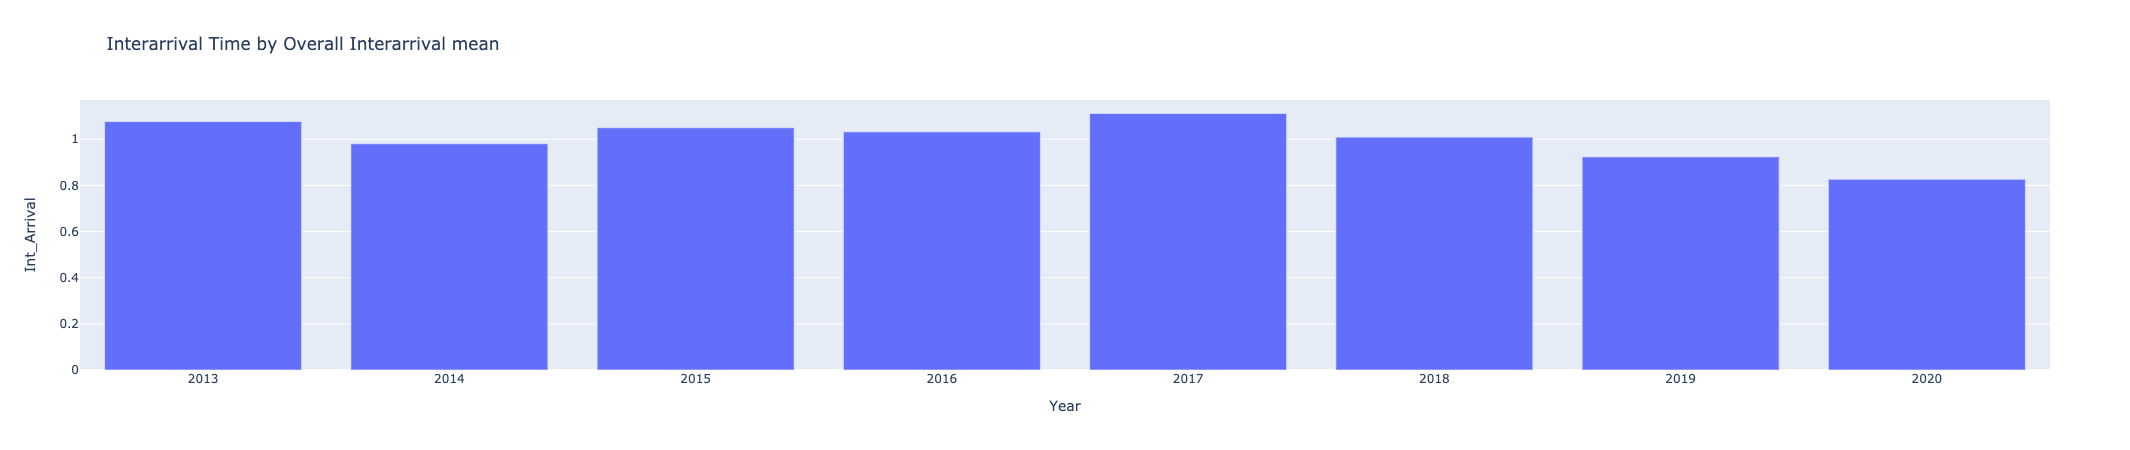

In [34]:
import plotly.express as px
fig = px.bar(annual_plot_df, x='Year', y='Int_Arrival', title='Interarrival Time by Overall Interarrival mean')
fig.show()

## ARRIVALS PER YEAR

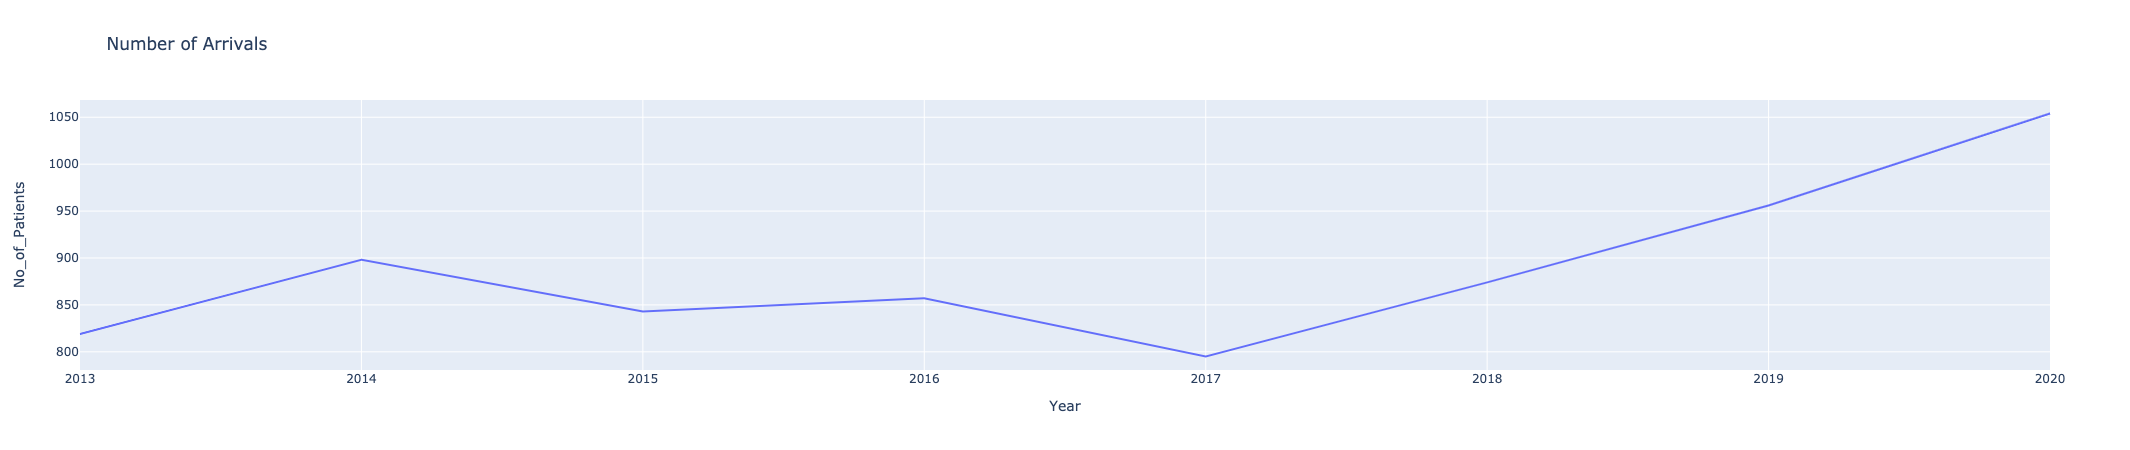

In [35]:
# PREPARE DATA FOR ARRIVALS PLOT
df = ideal_df
df = df.loc[df.Year == 2013,'Start'].min()
daysin2013 = df.dayofyear
percentdaysin2013 = (365 - daysin2013) / 365
df = ideal_df
df = df.loc[df.Year == 2020,'End'].max()
daysin2020 = df.dayofyear
percentdaysin2020 = daysin2020 / 365
df = ideal_df
df = df.loc[df.Int_Arrival.notnull(),('Year','Int_Arrival')]
df = df.groupby('Year').count()
df = df.reset_index()
df = df.rename(columns={'Int_Arrival':'No_of_Patients'})
nopatients2013 = df.loc[df.Year == 2013, 'No_of_Patients']
df.loc[df.Year == 2013, 'No_of_Patients'] = int(nopatients2013 / percentdaysin2013)
nopatients2020 = df.loc[df.Year == 2020, 'No_of_Patients']
df.loc[df.Year == 2020, 'No_of_Patients'] = int(nopatients2020 / percentdaysin2020)
#Export Plot to external sheet
df.to_csv("Arrivals_per_Year.csv", index=False)  
plot_arrivals_year = df
#Show plot of datat
fig = px.line(plot_arrivals_year, x='Year', y='No_of_Patients', title='Number of Arrivals')
fig.show()

##  IDEAL FLOW PROBABILITY

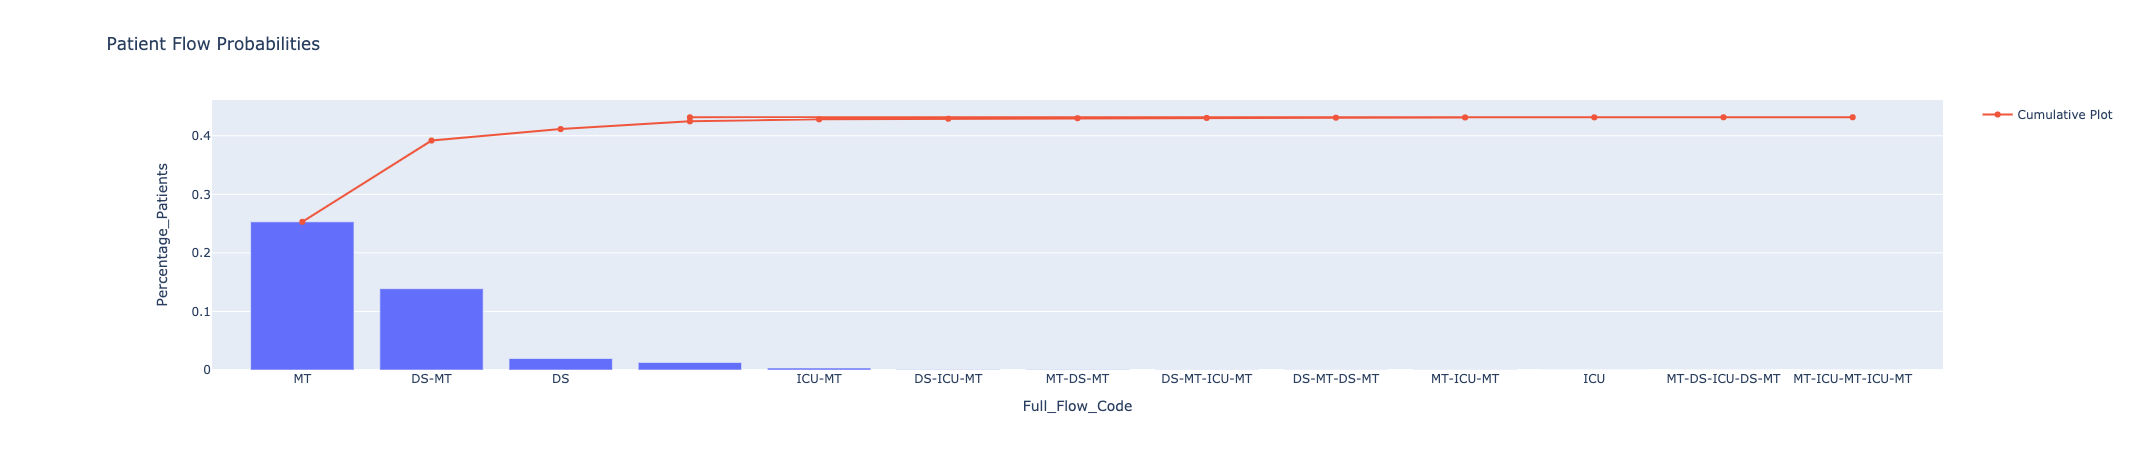

In [36]:
df = ideal_df
total_patients = df.count().iloc[0]
df = df.loc[df.Prev_Flow == 'IN'].groupby(['Full_Flow_Code']).count()['Link']
df = df.reset_index()
df = df.rename(columns={'Link':'No_of_Patients'})
df['Total_Patients'] = total_patients
df['Full_Flow_Code'] = df['Full_Flow_Code'].str[3:-4]
df = df.sort_values('No_of_Patients', ascending = False)
df['Percentage_Patients'] = df.No_of_Patients / df.Total_Patients
df['Cumulative_Probability'] = df.Percentage_Patients.cumsum()
df = df.drop(columns=['No_of_Patients','Total_Patients'])
ideal_patient_flow_prob_plot_df = df
df.to_csv("Ideal_Flow_Probability.csv", index=False)  
#Show plot of data
fig = px.bar(ideal_patient_flow_prob_plot_df, x=df['Full_Flow_Code'], y=df['Percentage_Patients'], title='Patient Flow Probabilities')
fig.add_scatter(x=df['Full_Flow_Code'], y=df['Cumulative_Probability'], name='Cumulative Plot')
fig.show()

In [37]:
ideal_patient_flow_prob_plot_df

,Full_Flow_Code,Percentage_Patients,Cumulative_Probability
12,MT,0.253033,0.253033
3,DS-MT,0.138820,0.391853
4,DS,0.019575,0.411428
13,,0.013234,0.424662
5,ICU-MT,0.003446,0.428109
0,DS-ICU-MT,0.000965,0.429074
9,MT-DS-MT,0.000896,0.429970
2,DS-MT-ICU-MT,0.000482,0.430452
1,DS-MT-DS-MT,0.000414,0.430866
11,MT-ICU-MT,0.000414,0.431279


## BRANCHING PROBABILITIES

In [38]:
####### Data Table for Pie Charts
# Split Full flow code data up
df = ideal_df.copy(deep=True)
df = df.loc[df.Prev_Flow == 'IN'].groupby('Full_Flow_Code').count()['Link'].reset_index()
df1 = df.Full_Flow_Code.str.split(pat="-", expand=True)
df = pd.merge(df, df1, left_index=True, right_index=True)
df = df.rename(columns={'Link':'Values'})
# format each level correctly for plats
lvl1_df = df.iloc[:]
lvl1_df['Prev_Flow'] = df[0]
lvl1_df['Ward_Code'] = df[1]
lvl2_df = df.iloc[:]
lvl2_df['Prev_Flow'] = df[0] + '-' + df[1]
lvl2_df['Ward_Code'] = df[2]
lvl3_df = df.iloc[:]
lvl3_df['Prev_Flow'] = df[0]+'-'+df[1]+'-'+df[2]
lvl3_df['Ward_Code'] = df[3]
lvl4_df = df.iloc[:]
lvl4_df['Prev_Flow'] = df[0]+'-'+df[1]+'-'+df[2]+'-'+df[3]
lvl4_df['Ward_Code'] = df[4]
lvl5_df = df.iloc[:]
lvl5_df['Prev_Flow'] = df[0]+'-'+df[1]+'-'+df[2]+'-'+df[3]+'-'+df[4]
lvl5_df['Ward_Code'] = df[5]
lvl6_df = df.iloc[:]
lvl6_df['Prev_Flow'] = df[0]+'-'+df[1]+'-'+df[2]+'-'+df[3]+'-'+df[4]+'-'+df[5]
lvl6_df['Ward_Code'] = df[6]
#bring information back into single dataframe
df = pd.concat([lvl1_df,lvl2_df,lvl3_df,lvl4_df,lvl5_df,lvl6_df])
df = df.dropna(subset=['Ward_Code'])
df = df.drop(columns=['Full_Flow_Code',0,1,2,3,4,5,6])
pie_df = df.copy(deep = True)
pie_df.head()

,Values,Prev_Flow,Ward_Code
0,14,IN,DS
1,6,IN,DS
2,7,IN,DS
3,2014,IN,DS
4,284,IN,DS


In [39]:
def flow_code_pie_chart(df, prev_flow_code):
    title = prev_flow_code
    filename = 'plots/Patient_Flow/' + title + '.png'
    df = df.loc[df.Prev_Flow == title].groupby('Ward_Code').sum()['Values'].reset_index()
    fig = px.pie(
        data_frame=df,
        values='Values',
        names='Ward_Code',
        color='Ward_Code',
        color_discrete_map = {'MT':'royalblue',
                             'DS':'green',
                             'ICU':'goldenrod',
                             'OUT':'salmon'},
        labels={'Ward_Code':'Next Ward'},
        title=title,
        template='presentation',
        width=800,
        height=600,
        hole=0
    )
    fig.update_traces(textinfo='percent+label')
    #fig.show()
    fig.write_image(filename)
#flow_code_pie_chart(pie_df, 'IN-DS') 
    
def all_flow_code_pie_charts(df):
    temp_df = df.groupby('Prev_Flow').count()['Values'].reset_index()
    for entry in temp_df['Prev_Flow']:
        flow_code_pie_chart(df, entry)
        
%time all_flow_code_pie_charts(pie_df)

CPU times: user 500 ms, sys: 8.41 ms, total: 508 ms
Wall time: 1.05 s


## VERIFICATION OF DATA

In [40]:
df = orig_df
#df = ideal_df

In [41]:
df.loc[df.Prev_Flow=='IN'].groupby('Ward_Code').count()['Link']
#df.groupby('Full_Flow_Code').count()['Link']
#df.count()['Link']
#df.loc[df.Prev_Flow=='IN'].groupby('Full_Flow_Code').count()['Link']
#df.groupby('Full_Flow_Code').count()['Link']

Ward_Code
CA       59
CL      126
DPS     191
DS     2325
HE        4
ICU      52
MT     3504
ON        1
Name: Link, dtype: int64

In [42]:
#IN-DS-MT-OUT
#df.loc[(df.Full_Flow_Code=='IN-DS-MT-OUT')&(df.Prev_Flow=='IN'),('Link',"Ward_Code",'Start','End','Prev_Flow','Next_Ward')].sort_values(['Link','Start'])
#IN-MT-OUT
df.loc[(df.Full_Flow_Code=='IN-MT-OUT')&(df.Prev_Flow=='IN'),('Link',"Ward_Code",'Start','End','Prev_Flow','Next_Ward')].sort_values(['Link','Start'])

,Link,Ward_Code,Start,End,Prev_Flow,Next_Ward
0,ADE-271165,MT,2013-06-30 22:21:00,2013-07-04 10:40:00,IN,OUT
3,ADE-271551,MT,2013-06-27 23:54:00,2013-07-01 09:25:00,IN,OUT
10,ADE-271574,MT,2013-07-04 15:18:00,2013-07-07 10:45:00,IN,OUT
19,ADE-272231,MT,2013-07-26 21:20:00,2013-07-30 09:28:00,IN,OUT
20,ADE-272234,MT,2013-07-13 21:07:00,2013-07-17 11:10:00,IN,OUT
...,...,...,...,...,...,...
8978,ADE-509577,MT,2020-07-14 06:30:00,2020-07-18 16:10:00,IN,OUT
8979,ADE-509578,MT,2020-07-14 08:54:00,2020-07-19 09:00:00,IN,OUT
8982,ADE-509712,MT,2020-07-15 05:30:00,2020-07-18 11:33:00,IN,OUT
8983,ADE-509841,MT,2020-07-16 12:03:00,2020-07-19 12:04:00,IN,OUT


In [145]:
arrivalsum_df.head(30)

Arrival_Probability
Event_Activity Day_Type Admission_Period Int_Arrival_Bins                     
High           Weekday  Planned          (0, 9]                       0.739286
                                         (9, 19]                      0.907143
                                         (19, 29]                     0.978571
                                         (29, 49]                     0.985714
                                         (49, 59]                     0.992857
                                         (59, 69]                     1.000000
                        Unplanned        (0, 9]                       0.716495
                                         (9, 19]                      0.948454
                                         (19, 29]                     0.979381
                                         (29, 49]                     1.000000
               Weekend  Planned          (0, 9]                       0.400000
                                         (9, 19]                      0.525000
                                         (19, 29]                     0.850000
                                         (29, 49]                     0.975000
                                         (49, 59]                     1.000000
                        Unplanned        (0, 9]                       0.333333
                                         (9, 19]                      0.833333
                                         (19, 29]                     0.958333
                                         (29, 49]                     1.000000
Low            Weekday  Planned          (0, 9]                       0.547368
                                         (9, 19]                      0.642105
                                         (19, 29]                     0.821053
                                         (29, 49]                     0.915789
                                         (49, 59]                     0.947368
                                         (59, 69]                     0.968421
                                         (69, 79]                     0.978947
                                         (79, 89]                     0.989474
                                         (89, 99]                     1.000000
                        Unplanned        (0, 9]                       0.428571
                                         (9, 19]                      0.761905

In [150]:
patientflowsum_df.head(50)

Next_Ward_Cum_Prob
Event_Activity Day_Type Admission_Period Prev_Flow    Ward_Code                   
High           Weekday  Planned          IN           DS                  0.447183
                                                      ICU                 0.461268
                                                      MT                  0.996479
                                                      OUT                        1
                                         IN-DS        ICU                     0.04
                                                      MT                       0.9
                                                      OUT                        1
                                         IN-DS-MT     OUT                        1
                                         IN-ICU       MT                         1
                                         IN-MT        OUT                        1
                        Unplanned        IN           DS                  0.212121
                                                      ICU                 0.217172
                                                      MT                  0.934343
                                                      OUT                        1
                                         IN-DS        MT                  0.885417
                                                      OUT                        1
                                         IN-DS-ICU-MT OUT                        1
                                         IN-DS-MT     OUT                        1
                                         IN-ICU       MT                         1
                                         IN-ICU-MT    OUT                        1
                                         IN-MT        OUT                        1
               Weekend  Planned          IN           DS                     0.575
                                                      MT                         1
                                         IN-DS        MT                     0.875
                                                      OUT                        1
                                         IN-DS-MT     OUT                        1
                                         IN-MT        OUT                        1
                        Unplanned        IN           DS                  0.291667
                                                      ICU                 0.333333
                                                      MT                         1
                                         IN-DS        MT                   0.96875
                                                      OUT                        1
                                         IN-DS-ICU    MT                         1
                                         IN-DS-MT     OUT                        1
                                         IN-MT        OUT                        1
Low            Weekday  Planned          IN           DS                  0.402062
                                                      MT                         1
                                         IN-DS        MT                  0.692308
                                                      OUT                        1
                                         IN-DS-MT     OUT                        1
                                         IN-MT        DS                  0.166667
                                                      OUT                        1
                        Unplanned        IN           DS                  0.309524
                                                      ICU                 0.333333
                                                      MT                         1
                                         IN-DS        ICU                0.0232558
                                                      MT                  0.8372

In [45]:
LOSsum_df.head(50)

LOS_Probability
Event_Activity Day_Type Admission_Period Prev_Flow Ward_Code LOS_Bins                   
High           Weekday  Planned          IN        DS        (0, 19]            0.393701
                                                             (19, 39]           0.905512
                                                             (39, 59]           0.992126
                                                             (59, 79]           1.000000
                                                   ICU       (0, 19]            1.250000
                                                             (19, 39]           1.500000
                                                             (39, 59]           2.000000
                                                   MT        (0, 19]            2.013158
                                                             (19, 39]           2.039474
                                                             (39, 59]           2.052632
                                                             (59, 79]           2.197368
                                                             (79, 99]           2.532895
                                                             (99, 119]          2.756579
                                                             (119, 139]         2.953947
                                                             (139, 159]         2.986842
                                                             (159, 179]         2.993421
                                                             (299, 319]         3.000000
                                         IN-DS     ICU       (39, 59]           4.000000
                                                   MT        (0, 19]            4.023256
                                                             (39, 59]           4.046512
                                                             (59, 79]           4.279070
                                                             (79, 99]           4.581395
                                                             (99, 119]          4.883721
                                                             (119, 139]         4.953488
                                                             (139, 159]         4.976744
                                                             (339, 359]         5.000000
                                         IN-ICU    MT        (19, 39]           5.500000
                                                             (159, 179]         6.000000
                        Unplanned        IN        DS        (0, 19]            0.357143
                                                             (19, 39]           0.976190
                                                             (39, 59]           1.000000
                                                   ICU       (19, 39]           2.000000
                                                   MT        (0, 19]            2.021127
                                                             (19, 39]           2.035211
                                                             (39, 59]           2.084507
                                                             (59, 79]           2.211268
                                                             (79, 99]           2.563380
                                                             (99, 119]          2.788732
                                                             (119, 139]         2.922535
                                                             (139, 159]         2.985915
                                                             (159, 179]         2.992958
                                                             (179, 199]         3.000000
                                         IN-DS     MT        (19, 39]           3.058824
                                                             (39, 59

## INTERPRETING RESULTS

In [46]:
sim_run.head()

,Sim_No,Link,Ward_Code,Start,End,Prev_Flow,Patient_to_MT,Patient_to_DS,MT_Occupancy,DS_Occupancy,Sim_Name
0,0,0,MT,2030-01-01 04:03:19,2030-01-01 12:47:54,IN,1,0,1,0,sim2030
1,0,0,OUT,2030-01-01 12:47:54,2030-01-01 12:47:54,IN-MT,-1,0,0,1,sim2030
2,0,1,DS,2030-01-01 10:16:26,2030-01-01 16:16:42,IN,0,1,1,1,sim2030
3,0,1,OUT,2030-01-01 16:16:42,2030-01-01 16:16:42,IN-DS,0,-1,0,0,sim2030
4,0,2,MT,2030-01-01 20:16:10,2030-01-02 00:32:34,IN,1,0,1,0,sim2030


In [47]:
ideal_df.groupby('Year').describe()['Int_Arrival']

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2013.0,420.0,10.684810,11.419996,0.0,2.6050,6.760,15.0275,75.32
2014.0,898.0,9.730334,10.669168,0.0,2.2800,6.430,13.8275,73.42
2015.0,843.0,10.419881,11.256173,0.0,2.5200,7.020,14.5950,106.00
2016.0,857.0,10.243279,11.869947,0.0,2.0000,5.750,14.5000,76.82
2017.0,795.0,11.032415,13.136971,0.0,2.3200,6.930,15.0850,86.77
2018.0,874.0,10.015355,11.369700,0.0,2.3050,6.435,13.8150,93.03
2019.0,956.0,9.167772,11.412305,0.0,1.8225,5.680,11.5200,97.00
2020.0,618.0,8.205162,9.906112,0.0,1.5000,4.890,11.3650,86.68


## REPORTS

In [48]:
timeconv_df

,Admission_Period,Hour_of_Day
0,Planned,0
1,Unplanned,1
2,Unplanned,2
3,Unplanned,3
4,Unplanned,4
5,Planned,5
6,Planned,6
7,Planned,7
8,Planned,8
9,Unplanned,9


In [49]:
event_activity_df

,Event_Activity,Event
0,High,AFTERXMAS
1,High,B4EASTER
2,High,BEFOREXMAS
3,Low,EASTER
4,Normal,NONE
5,Normal,SCHOOL
6,Low,XMAS
7,Low,PUBLIC


In [50]:
dayconv_df

,Day_Type,Day
0,Weekday,0
1,Weekday,1
2,Weekday,2
3,Weekday,3
4,Weekday,4
5,Weekend,5
6,Weekend,6
